#GAN implementation of MNIST dataset

##import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## load MNIST dataset

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=32, shuffle=True)

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
  print(batch_idx, data.shape, data, target)
  break

0 torch.Size([32, 1, 28, 28]) tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1

##implement a function to plot picures

In [ ]:
batch_idx, (pictures, labels) = next(enumerate(train_loader))
pictures.shape
# pictures

torch.Size([32, 1, 28, 28])

In [ ]:
import matplotlib.pyplot as plt

def plot_picture(picture, title=""):
  fig = plt.figure()
  plt.tight_layout()
  plt.imshow(picture, cmap='gray', interpolation='none')
  plt.title(title)
  plt.xticks([])
  plt.yticks([])

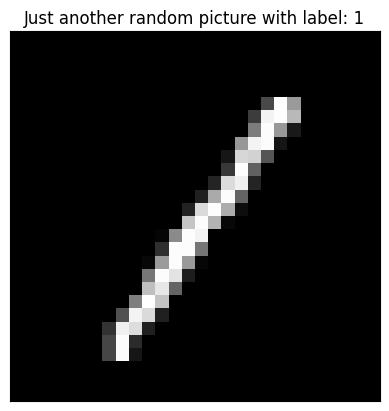

In [ ]:
plot_picture(pictures[1][0], f"Just another random picture with label: {labels[1]}")

##model

###Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_features = 100, out_features= 28*28):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.out = nn.Sequential(
            nn.Linear(1024, out_features),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.out(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

###discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_features=28*28, out_features=1):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.LeakyReLU(0.2),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.out(x)
        return x

###model

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (layer1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)
Discriminator(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer3): Sequen

In [ ]:
num_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print(f'Number of parameters for generator: {num_params}')
num_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f'Number of parameters for discriminator: {num_params}')

Number of parameters for generator: 1489936
Number of parameters for discriminator: 1460225


In [ ]:
criterion = nn.BCELoss()

lr = 0.0002
beta1 = 0.5
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

print(optimizer_g)
print(optimizer_d)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)


###learning model

In [ ]:
num_epochs = 30
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (pictures, labels) in enumerate(train_loader):
    # labels for training
    real_labels = torch.ones(32, 1).to(device)
    fake_labels = torch.zeros(32, 1).to(device)

    # train discriminator with real pictures from dataset
    optimizer_d.zero_grad()
    pictures = pictures.to(device)
    outputs = discriminator(pictures)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # train discriminator with fake pictures from generator
    noise = torch.randn(32, 100).to(device)
    fake_pictures = generator(noise)
    outputs = discriminator(fake_pictures)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_d.step()

    # train generator
    optimizer_g.zero_grad()
    noise = torch.randn(32, 100).to(device)
    fake_pictures = generator(noise)
    outputs = discriminator(fake_pictures)

    g_loss = criterion(outputs, real_labels)
    g_loss.backward()
    optimizer_g.step()

    # print(f"epoch: {epoch}/{num_epochs}, batch: {i}/{len(train_loader)}, g_loss: {g_loss.item():.4f}, d_loss: {d_loss.item():.4f}, D(x): {real_score.mean().item():.4f}, D(G(z)): {fake_score.mean().item():.4f}")

  print(f"epoch: {epoch+1}/{num_epochs}, g_loss: {g_loss.item():.4f}, d_loss: {d_loss.item():.4f}, D(x): {real_score.mean().item():.4f}, D(G(z)): {fake_score.mean().item():.4f}")

  # Save sampled images
  # if (epoch + 1) % 100 == 0:
  #     save_images(epoch + 1)


epoch: 1/30, g_loss: 1.3424, d_loss: 0.7567, D(x): 0.6704, D(G(z)): 0.2316
epoch: 2/30, g_loss: 2.0499, d_loss: 0.9121, D(x): 0.8142, D(G(z)): 0.4546
epoch: 3/30, g_loss: 0.9157, d_loss: 0.8445, D(x): 0.6390, D(G(z)): 0.2770
epoch: 4/30, g_loss: 1.1466, d_loss: 1.1733, D(x): 0.5479, D(G(z)): 0.3599
epoch: 5/30, g_loss: 1.0314, d_loss: 1.0728, D(x): 0.6660, D(G(z)): 0.4296
epoch: 6/30, g_loss: 1.1283, d_loss: 1.0785, D(x): 0.6717, D(G(z)): 0.4572
epoch: 7/30, g_loss: 0.9295, d_loss: 1.1525, D(x): 0.5395, D(G(z)): 0.3489
epoch: 8/30, g_loss: 1.1935, d_loss: 0.9974, D(x): 0.7019, D(G(z)): 0.4111
epoch: 9/30, g_loss: 0.7417, d_loss: 1.1377, D(x): 0.7064, D(G(z)): 0.5017
epoch: 10/30, g_loss: 0.7644, d_loss: 1.3029, D(x): 0.5384, D(G(z)): 0.4273
epoch: 11/30, g_loss: 1.2689, d_loss: 1.0953, D(x): 0.6576, D(G(z)): 0.4279
epoch: 12/30, g_loss: 1.0526, d_loss: 1.1330, D(x): 0.5637, D(G(z)): 0.3791
epoch: 13/30, g_loss: 1.3480, d_loss: 1.4108, D(x): 0.6497, D(G(z)): 0.5385
epoch: 14/30, g_loss:

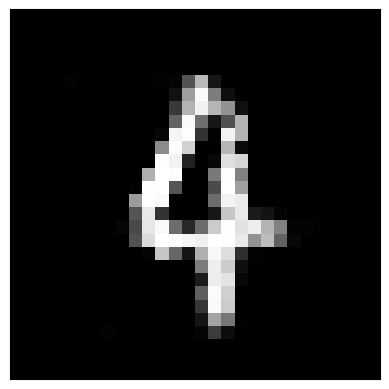

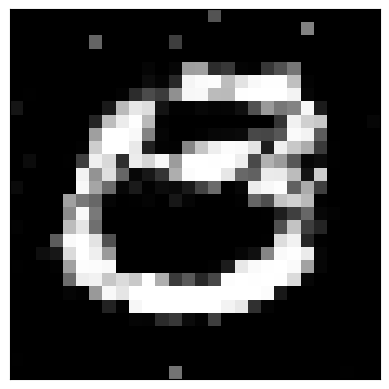

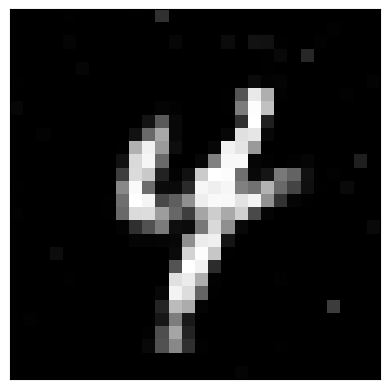

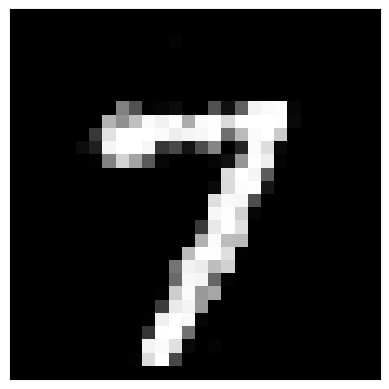

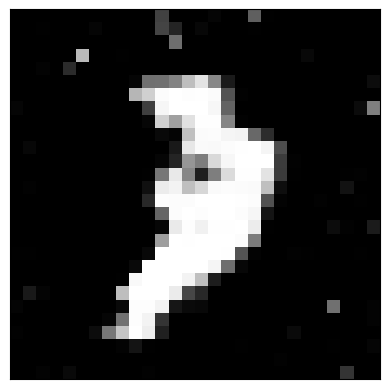

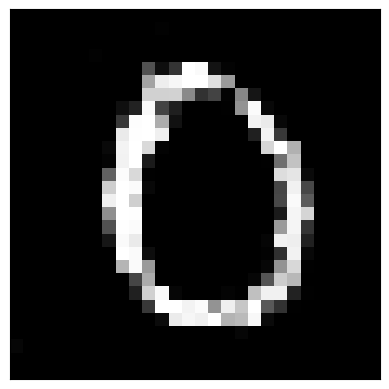

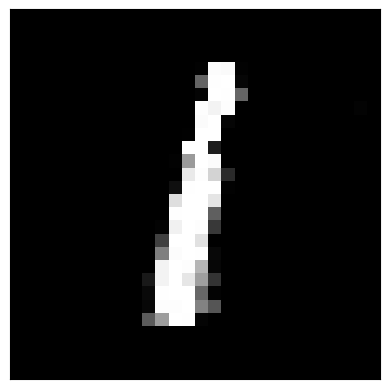

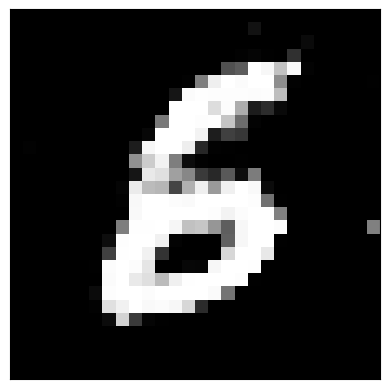

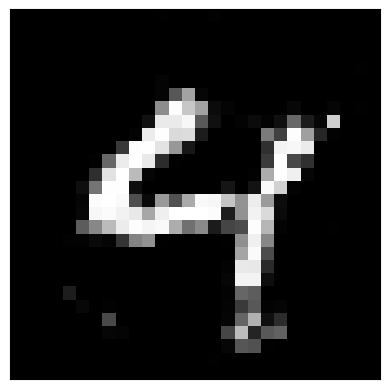

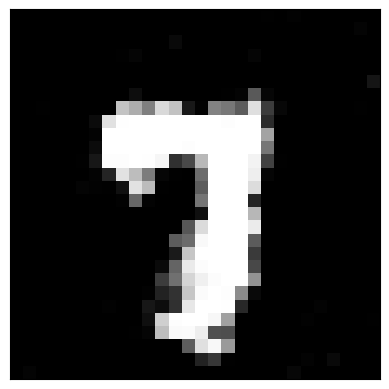

In [ ]:
noise = torch.randn(10, 100).to(device)
fake_pictures = generator(noise)
fake_pictures = fake_pictures.reshape(fake_pictures.size(0), 1, 28, 28)
fake_pictures = fake_pictures.cpu().detach().numpy()
for fake_picture in fake_pictures:
  plot_picture(fake_picture[0])
